In [1]:
import os
import pandas as pd
from GraphBuild import * 
import matplotlib.pyplot as plt
import random

In [2]:
# Loading PV information
PVs = [{'no':1, 'bus':'890', 'numphase':3, 'phaseconn':'.1.2.3', 'size':146, 'kV':4.16},
       {'no':2, 'bus':'806', 'numphase':3, 'phaseconn':'.1.2.3', 'size':144, 'kV':24.9},
       {'no':3, 'bus':'816', 'numphase':3, 'phaseconn':'.1.2.3', 'size':200, 'kV':24.9}]

### Building circuit with PV

In [3]:
# Initialize Circuit
FolderName = os.path.dirname(os.path.realpath("__file__"))
DSSfile = r""+ FolderName+ "\ieee34Mod1.dss"
Ckt_obj = CircuitSetup(DSSfile, PVs)  #creating a DSS object instance
G_original =  build_graph(Ckt_obj)
nx.readwrite.gml.write_gml(G_original,"34busEx.gml") #Graph undirected with edge features and node features which are constant

In [4]:
node_list=list(G_original.nodes())
edge_list=list(G_original.edges())

### Loadshapes Restructure

In [5]:
input_file = 'LoadShape1.xlsx'
sheet_name = 'LoadShape1'  # Change to the sheet you want to split
df = pd.read_excel(input_file, sheet_name=sheet_name)

points_per_day = 24  # Assuming 1-hour resolution (24 points = 24 hours)
# Convert to flat list
loadshape_values = df.iloc[:, 0].values.tolist()
# Check total number of complete days available
num_days = len(loadshape_values) // points_per_day
# Slice the loadshape into daily
LoadShapes = []
for i in range(num_days):
    start_idx = i * points_per_day
    end_idx = (i + 1) * points_per_day
    daily_shape = loadshape_values[start_idx:end_idx]
    LoadShapes.append(daily_shape)

In [6]:
# Load the file, skip first metadata row
irradiance_df = pd.read_csv('5mins Irradiance Data (NSRDB).csv', skiprows=2)
irradiance_df.columns
ghi_values = irradiance_df['GHI'].values
# Settings
points_per_day = 288  # 5-minute resolution
num_days = len(ghi_values) // points_per_day
# Slice into daily irradiance profiles
IrradianceShapes = []

for i in range(num_days):
    start_idx = i * points_per_day
    end_idx = (i + 1) * points_per_day
    daily_ghi = ghi_values[start_idx:end_idx]
    IrradianceShapes.append(daily_ghi)

### Select Loadshapes and Perform Time series evaluation

In [14]:
# Select day 0
loadshape_day = LoadShapes[10]  # 24 points
irradiance_day = IrradianceShapes[200]  # 288 points

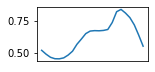

In [21]:
# -- Plot 2: PV Output Power over Time --
plt.figure(figsize=(2,1))
plt.plot(loadshape_day)
# plt.grid(True)
plt.xticks([]) 
plt.savefig("load.png", dpi=300, bbox_inches='tight')

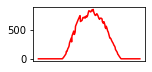

In [22]:
# -- Plot 2: PV Output Power over Time --
plt.figure(figsize=(2,1))
plt.plot(irradiance_day,color='red')
# plt.grid(True)
plt.xticks([]) 
plt.savefig("irradiance.png", dpi=300, bbox_inches='tight')

In [8]:
# Create the LoadShape in opendss
Ckt_obj.dss.Text.Command(f"New LoadShape.LoadVar npts={len(loadshape_day)} interval=1 mult=(" + ' '.join(map(str, loadshape_day)) + ")")

In [9]:
# Create the irradiance in opendss
Ckt_obj.dss.Text.Command(
    f"New LoadShape.IrradVar npts={len(irradiance_day)} minterval=5 mult=({' '.join(map(str, irradiance_day))})"
)

# Step 2: Normalize it
Ckt_obj.dss.Text.Command("edit LoadShape.IrradVar action=normalize")

In [10]:
# Assign Load shapes
Ckt_obj.dss.Text.Command("BatchEdit Load..* daily=LoadVar")
Ckt_obj.dss.Text.Command("BatchEdit PVSystem..* daily=IrradVar irradiance=1 tdaily=")
Ckt_obj.dss.Solution.Solve()

In [11]:
# Time series power flow
target_bus = '890'
voltages_over_time = []
PV_over_time = []
Load_over_time = []
times = []

Ckt_obj.dss.Text.Command("Set mode=daily")
Ckt_obj.dss.Text.Command("Set stepsize=30m")
Ckt_obj.dss.Text.Command("Set number=1")

t= 0
while t<24:
        Ckt_obj.dss.Solution.Solve()
        
        # Voltage at target bus
        Ckt_obj.dss.Circuit.SetActiveBus(target_bus)
        Vmag = Ckt_obj.dss.Bus.puVmagAngle()[::2]  # just magnitude
        voltages_over_time.append(Vmag)
        
        # PV output (sum of real powers of phases)
        Ckt_obj.dss.Circuit.SetActiveElement("PVSystem.PV1")
        powers = Ckt_obj.dss.CktElement.Powers()[::2]
        PV_over_time.append(-1*sum(powers))
        
        # Load demand (sum of real powers of phases)
        Ckt_obj.dss.Circuit.SetActiveElement("Load.s860")
        demand = Ckt_obj.dss.CktElement.Powers()[::2]
        Load_over_time.append(sum(demand))  
        
        t = Ckt_obj.dss.Solution.DblHour()
        times.append(t)

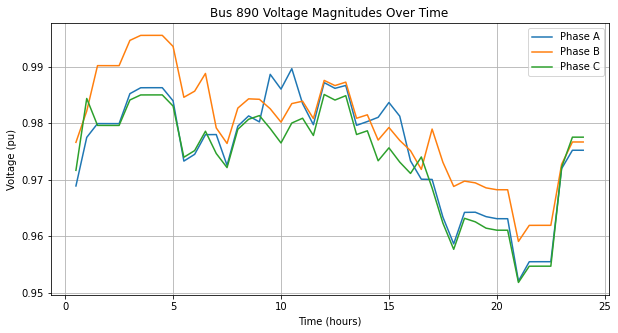

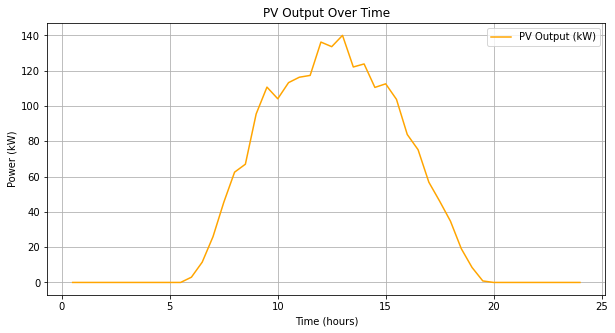

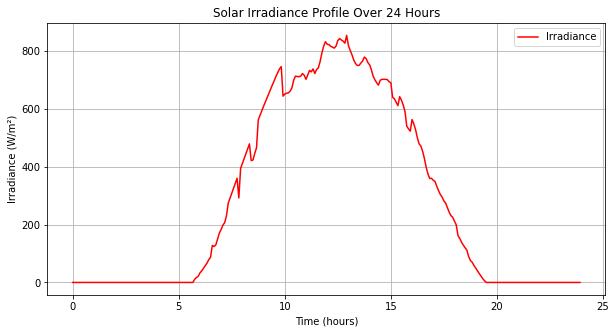

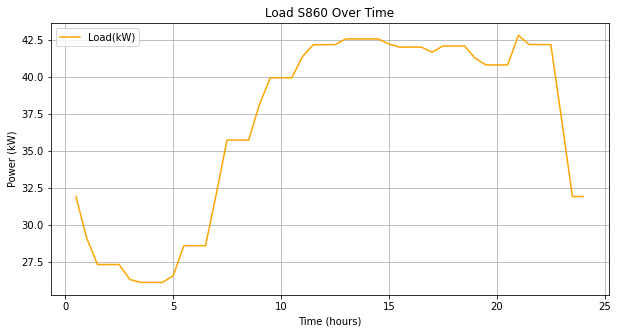

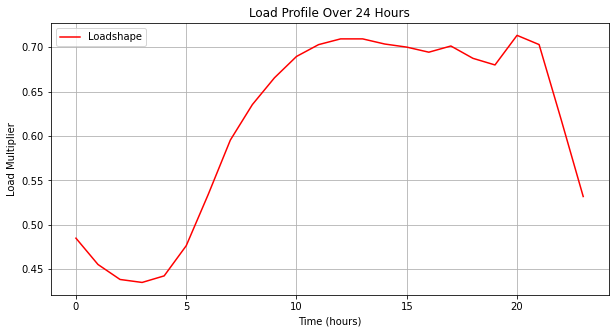

In [12]:
# -- Plot 1: 3-Phase Voltage Magnitudes over Time --
plt.figure(figsize=(10,5))
plt.plot(times, [v[0] for v in voltages_over_time], label="Phase A")
plt.plot(times, [v[1] for v in voltages_over_time], label="Phase B")
plt.plot(times, [v[2] for v in voltages_over_time], label="Phase C")
plt.xlabel("Time (hours)")
plt.ylabel("Voltage (pu)")
plt.title(f"Bus {target_bus} Voltage Magnitudes Over Time")
plt.grid(True)
plt.legend()
plt.show()

# -- Plot 2: PV Output Power over Time --
plt.figure(figsize=(10,5))
plt.plot(times, PV_over_time, label="PV Output (kW)", color='orange')
plt.xlabel("Time (hours)")
plt.ylabel("Power (kW)")
plt.title("PV Output Over Time")
plt.grid(True)
plt.legend()
plt.show()

# Times matching 30-minute steps
irr_times = [i * 5/60 for i in range(len(irradiance_day))]  # 0.0, 0.5, 1.0, ..., 23.5

# Plot
plt.figure(figsize=(10,5))
plt.plot(irr_times, irradiance_day, label="Irradiance", color='red')
plt.xlabel("Time (hours)")
plt.ylabel("Irradiance (W/m²)")
plt.title("Solar Irradiance Profile Over 24 Hours")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(times, Load_over_time, label="Load(kW)", color='orange')
plt.xlabel("Time (hours)")
plt.ylabel("Power (kW)")
plt.title("Load S860 Over Time")
plt.grid(True)
plt.legend()
plt.show()

# Plot
plt.figure(figsize=(10,5))
plt.plot(range(24), loadshape_day, label="Loadshape", color='red')
plt.xlabel("Time (hours)")
plt.ylabel("Load Multiplier")
plt.title("Load Profile Over 24 Hours")
plt.grid(True)
plt.legend()
plt.show()



### Power set point  and DOS Attack

In [21]:
Ckt_obj.dss.Text.Command(
    f"New LoadShape.IrradAttack")

In [22]:
# Edit load shapes (Load and PV) for each scenario
loadshape_day = random.choice(LoadShapes) # 24 points
irradiance_day =random.choice(IrradianceShapes)   # 288 points

In [23]:
# Edit the LoadShape in opendss
Ckt_obj.dss.Text.Command(f"Edit LoadShape.LoadVar npts={len(loadshape_day)} interval=1 mult=(" + ' '.join(map(str, loadshape_day)) + ")")
Ckt_obj.dss.Text.Command(
    f"Edit LoadShape.IrradVar npts={len(irradiance_day)} minterval=5 mult=({' '.join(map(str, irradiance_day))})"
)

# Step 2: Normalize it
Ckt_obj.dss.Text.Command("Edit LoadShape.IrradVar action=normalize")

In [24]:
# Select PV(s) which are under attack
num_attacked = random.randint(1, len(PVs)) # no. of PVs under attack
attacked_PVs = random.sample(PVs, k=num_attacked) # index of attacked PVs

In [25]:
attacked_PVs

[{'no': 1,
  'bus': '890',
  'numphase': 3,
  'phaseconn': '.1.2.3',
  'size': 146,
  'kV': 4.16}]

In [26]:
# Define PV attack window
# active window: 10am to 4pm → 120 to 192 (5-min steps)
start_idx = random.randint(120, 192)  # 10:00 to 16:00  
max_steps = min(48, 288 - start_idx)    # max 4 hours = 48 steps
attack_len = random.randint(12, max_steps)  # minimum 1 hour (12 steps)
end_idx = start_idx + attack_len
# Choose attack multiplier (power curtailment)
attack_mult = round(random.uniform(0.1, 0.7), 2) 
attack_irradiance = irradiance_day.copy()
# Change irradiance during the attack window
for i in range(start_idx, end_idx):
    attack_irradiance[i] *= attack_mult

In [27]:
# Edit the LoadShape in opendss
Ckt_obj.dss.Text.Command(
    f"Edit LoadShape.IrradAttack npts={len(attack_irradiance)} minterval=5 mult=({' '.join(map(str, attack_irradiance))})"
)

# Step 2: Normalize it
Ckt_obj.dss.Text.Command("Edit LoadShape.IrradAttack action=normalize")

In [28]:
# Assign Load shapes
Ckt_obj.dss.Text.Command("BatchEdit Load..* daily=LoadVar")

for gen in PVs:
    if gen in attacked_PVs: 
        Ckt_obj.dss.Text.Command(f"Edit PVSystem.PV{str(gen['no'])} daily=IrradAttack irradiance=1 tdaily=")
    else:
        Ckt_obj.dss.Text.Command(f"Edit PVSystem.PV{str(gen['no'])} daily=IrradVar irradiance=1 tdaily=")
Ckt_obj.dss.Solution.Solve()

In [29]:
# Time series power flow
target_bus = '890'
voltages_over_time = []
PV_over_time = []
Load_over_time = []
times = []

Ckt_obj.dss.Text.Command("Set mode=daily")
Ckt_obj.dss.Text.Command("Set stepsize=30m")
Ckt_obj.dss.Text.Command("Set number=1")

t= 0
while t<24:
        Ckt_obj.dss.Solution.Solve()
        
        # Voltage at target bus
        Ckt_obj.dss.Circuit.SetActiveBus(target_bus)
        Vmag = Ckt_obj.dss.Bus.puVmagAngle()[::2]  # just magnitude
        voltages_over_time.append(Vmag)
        
        # PV output (sum of real powers of phases)
        Ckt_obj.dss.Circuit.SetActiveElement("PVSystem.PV1")
        powers = Ckt_obj.dss.CktElement.Powers()[::2]
        PV_over_time.append(-1*sum(powers))
        
        # Load demand (sum of real powers of phases)
        Ckt_obj.dss.Circuit.SetActiveElement("Load.s860")
        demand = Ckt_obj.dss.CktElement.Powers()[::2]
        Load_over_time.append(sum(demand))  
        
        t = Ckt_obj.dss.Solution.DblHour()
        times.append(t)

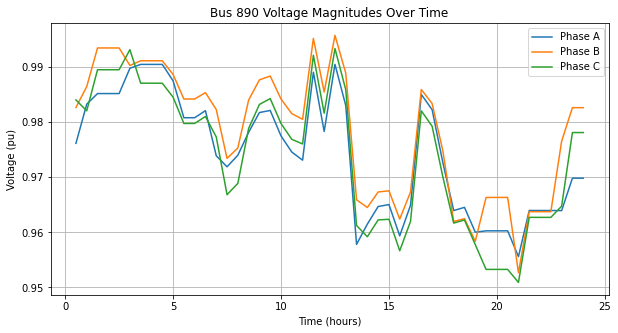

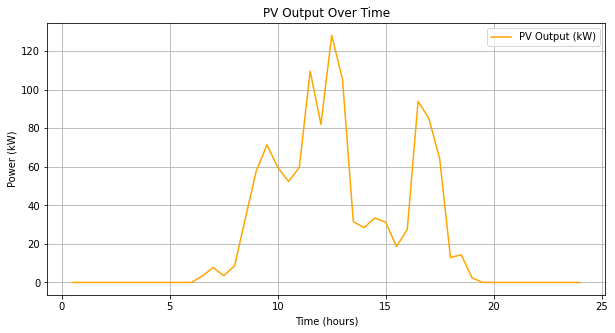

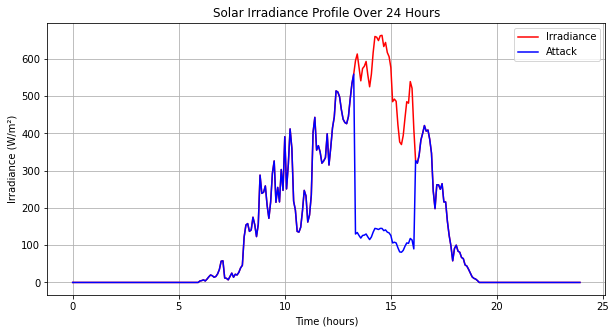

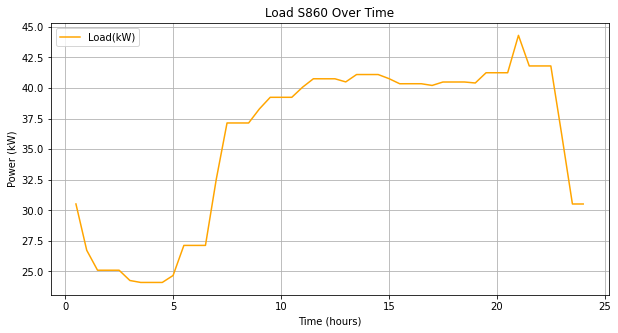

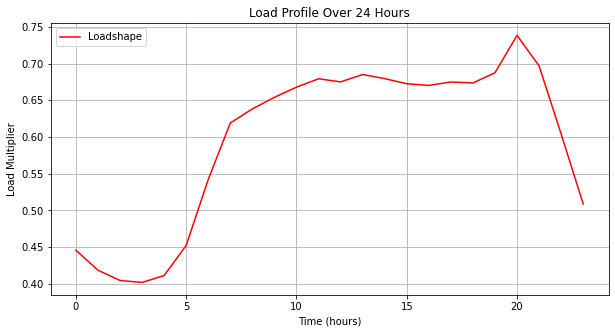

In [30]:
# -- Plot 1: 3-Phase Voltage Magnitudes over Time --
plt.figure(figsize=(10,5))
plt.plot(times, [v[0] for v in voltages_over_time], label="Phase A")
plt.plot(times, [v[1] for v in voltages_over_time], label="Phase B")
plt.plot(times, [v[2] for v in voltages_over_time], label="Phase C")
plt.xlabel("Time (hours)")
plt.ylabel("Voltage (pu)")
plt.title(f"Bus {target_bus} Voltage Magnitudes Over Time")
plt.grid(True)
plt.legend()
plt.show()

# -- Plot 2: PV Output Power over Time --
plt.figure(figsize=(10,5))
plt.plot(times, PV_over_time, label="PV Output (kW)", color='orange')
plt.xlabel("Time (hours)")
plt.ylabel("Power (kW)")
plt.title("PV Output Over Time")
plt.grid(True)
plt.legend()
plt.show()

# Times matching 30-minute steps
irr_times = [i * 5/60 for i in range(len(irradiance_day))]  # 0.0, 0.5, 1.0, ..., 23.5

# Plot
plt.figure(figsize=(10,5))
plt.plot(irr_times, irradiance_day, label="Irradiance", color='red')
plt.plot(irr_times, attack_irradiance, label="Attack", color='blue')
plt.xlabel("Time (hours)")
plt.ylabel("Irradiance (W/m²)")
plt.title("Solar Irradiance Profile Over 24 Hours")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(times, Load_over_time, label="Load(kW)", color='orange')
plt.xlabel("Time (hours)")
plt.ylabel("Power (kW)")
plt.title("Load S860 Over Time")
plt.grid(True)
plt.legend()
plt.show()

# Plot
plt.figure(figsize=(10,5))
plt.plot(range(24), loadshape_day, label="Loadshape", color='red')
plt.xlabel("Time (hours)")
plt.ylabel("Load Multiplier")
plt.title("Load Profile Over 24 Hours")
plt.grid(True)
plt.legend()
plt.show()



### Powerfactor Attack

In [41]:
# Edit load shapes (Load and PV) for each scenario
loadshape_day = random.choice(LoadShapes) # 24 points
irradiance_day =random.choice(IrradianceShapes)   # 288 points

In [42]:
# Edit the LoadShape in opendss
Ckt_obj.dss.Text.Command(f"Edit LoadShape.LoadVar npts={len(loadshape_day)} interval=1 mult=(" + ' '.join(map(str, loadshape_day)) + ")")
Ckt_obj.dss.Text.Command(
    f"Edit LoadShape.IrradVar npts={len(irradiance_day)} minterval=5 mult=({' '.join(map(str, irradiance_day))})"
)

# Step 2: Normalize it
Ckt_obj.dss.Text.Command("Edit LoadShape.IrradVar action=normalize")

In [43]:
# Select PV(s) which are under attack
num_attacked = random.randint(1, len(PVs)) # no. of PVs under attack
attacked_PVs = random.sample(PVs, k=num_attacked) # index of attacked PVs

In [44]:
attacked_PVs

[{'no': 2,
  'bus': '806',
  'numphase': 3,
  'phaseconn': '.1.2.3',
  'size': 144,
  'kV': 24.9},
 {'no': 1,
  'bus': '890',
  'numphase': 3,
  'phaseconn': '.1.2.3',
  'size': 146,
  'kV': 4.16}]

In [45]:
# Define PV attack window
# active window: 10am to 4pm → 120 to 192 (5-min steps)
start_idx = random.randint(120, 192)  # 10:00 to 16:00  
max_steps = min(48, 288 - start_idx)    # max 4 hours = 48 steps
attack_len = random.randint(12, max_steps)  # minimum 1 hour (12 steps)
end_idx = start_idx + attack_len
pf_attack = round(random.uniform(0.5, 0.7), 2)

In [46]:
# Assign Load shapes
Ckt_obj.dss.Text.Command("BatchEdit Load..* daily=LoadVar")
Ckt_obj.dss.Text.Command("BatchEdit PVSystem..* daily=IrradVar irradiance=1 tdaily=")
Ckt_obj.dss.Solution.Solve()

In [47]:
pf_attack

0.62

In [48]:
# Time series power flow
target_bus = '890'
voltages_over_time = []
PV_over_time = [] 
PF_over_time = [] 
times = []

Ckt_obj.dss.Text.Command("Set mode=daily")
Ckt_obj.dss.Text.Command("Set stepsize=30m")
Ckt_obj.dss.Text.Command("Set number=1")

t= 0
while t<24:
        Ckt_obj.dss.Solution.Solve()
        if start_idx * 5 / 60 <= t < end_idx * 5 / 60:
            for pv in attacked_PVs:
                Ckt_obj.dss.Text.Command(f"Edit PVSystem.PV{pv['no']} pf={pf_attack}")  # Force poor power factor
        else:
            for pv in attacked_PVs:
                Ckt_obj.dss.Text.Command(f"Edit PVSystem.PV{pv['no']} pf=0.95")  # Restore normal

        # Voltage at target bus
        Ckt_obj.dss.Circuit.SetActiveBus(target_bus)
        Vmag = Ckt_obj.dss.Bus.puVmagAngle()[::2]  # just magnitude
        voltages_over_time.append(Vmag)
        
        Ckt_obj.dss.Circuit.SetActiveElement("PVSystem.PV1")
        powers = Ckt_obj.dss.CktElement.Powers()
        P = sum(powers[::2])     # Real power across phases
        Q = sum(powers[1::2])    # Reactive power across phases

        if P == 0 and Q == 0:
            pf = 1.0  # Avoid division by zero; assume unity when off
        else:
            pf = abs(P) / (P**2 + Q**2)**0.5

        PV_over_time.append(-1 * P)
        PF_over_time.append(pf)        

        t = Ckt_obj.dss.Solution.DblHour()
        times.append(t)

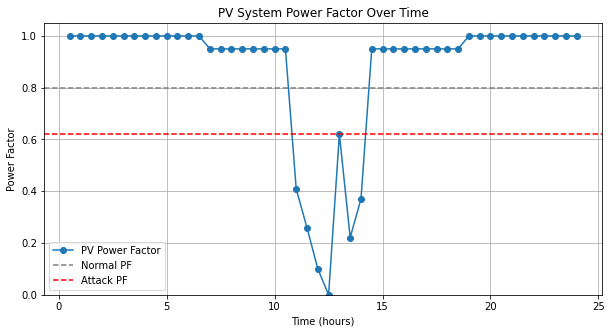

In [49]:
plt.figure(figsize=(10, 5))
plt.plot(times, PF_over_time, marker='o', label='PV Power Factor')
plt.axhline(y=0.8, color='gray', linestyle='--', label='Normal PF')
plt.axhline(y=pf_attack, color='red', linestyle='--', label='Attack PF')
plt.xlabel("Time (hours)")
plt.ylabel("Power Factor")
plt.title("PV System Power Factor Over Time")
plt.grid(True)
plt.ylim(0.0, 1.05)
plt.legend()
plt.show()

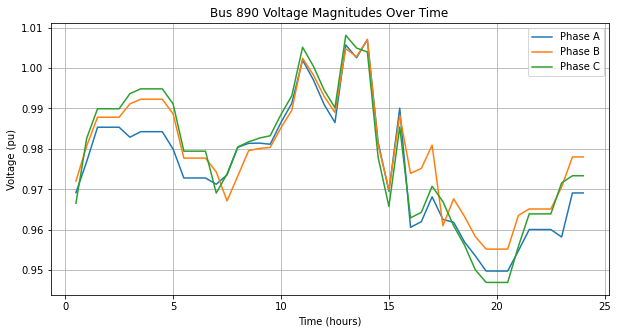

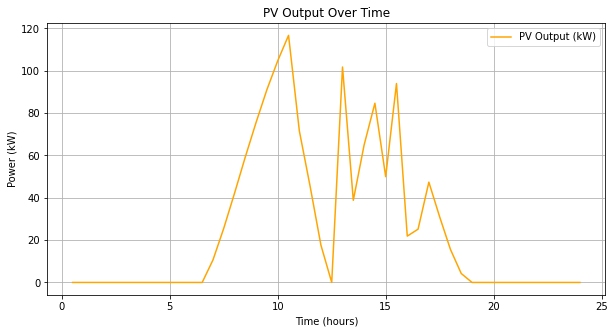

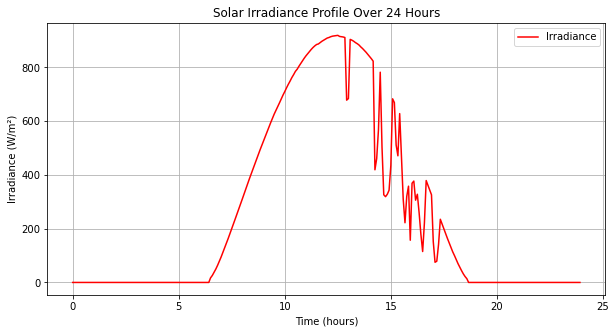

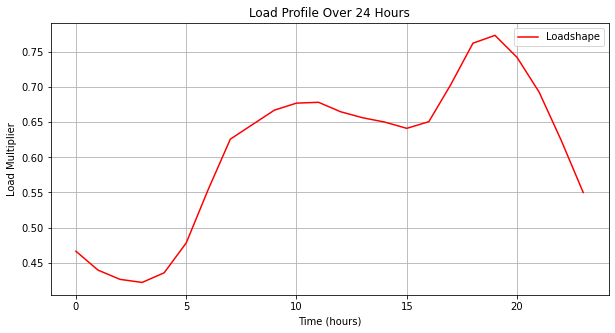

In [50]:
# -- Plot 1: 3-Phase Voltage Magnitudes over Time --
plt.figure(figsize=(10,5))
plt.plot(times, [v[0] for v in voltages_over_time], label="Phase A")
plt.plot(times, [v[1] for v in voltages_over_time], label="Phase B")
plt.plot(times, [v[2] for v in voltages_over_time], label="Phase C")
plt.xlabel("Time (hours)")
plt.ylabel("Voltage (pu)")
plt.title(f"Bus {target_bus} Voltage Magnitudes Over Time")
plt.grid(True)
plt.legend()
plt.show()


# -- Plot 2: PV Output Power over Time --
plt.figure(figsize=(10,5))
plt.plot(times, PV_over_time, label="PV Output (kW)", color='orange')
plt.xlabel("Time (hours)")
plt.ylabel("Power (kW)")
plt.title("PV Output Over Time")
plt.grid(True)
plt.legend()
plt.show()


# Times matching 30-minute steps
irr_times = [i * 5/60 for i in range(len(irradiance_day))]  # 0.0, 0.5, 1.0, ..., 23.5


# Plot
plt.figure(figsize=(10,5))
plt.plot(irr_times, irradiance_day, label="Irradiance", color='red')
plt.xlabel("Time (hours)")
plt.ylabel("Irradiance (W/m²)")
plt.title("Solar Irradiance Profile Over 24 Hours")
plt.grid(True)
plt.legend()
plt.show()


# Plot
plt.figure(figsize=(10,5))
plt.plot(range(24), loadshape_day, label="Loadshape", color='red')
plt.xlabel("Time (hours)")
plt.ylabel("Load Multiplier")
plt.title("Load Profile Over 24 Hours")
plt.grid(True)
plt.legend()
plt.show()



### Mixed attacks

In [7]:
Ckt_obj.dss.Text.Command(
    f"New LoadShape.IrradAttack")
Ckt_obj.dss.Text.Command(
    f"New LoadShape.LoadVar")
Ckt_obj.dss.Text.Command(
    f"New LoadShape.IrradVar")

In [8]:
# Edit load shapes (Load and PV) for each scenario
loadshape_day = random.choice(LoadShapes) # 24 points
irradiance_day =random.choice(IrradianceShapes)   # 288 points

In [9]:
# Select PV(s) which are under attack
num_attacked = random.randint(1, len(PVs)) # no. of PVs under attack
attacked_PVs = random.sample(PVs, k=num_attacked) # index of attacked PVs

In [10]:
attacked_PVs

[{'no': 1,
  'bus': '890',
  'numphase': 3,
  'phaseconn': '.1.2.3',
  'size': 146,
  'kV': 4.16},
 {'no': 3,
  'bus': '816',
  'numphase': 3,
  'phaseconn': '.1.2.3',
  'size': 200,
  'kV': 24.9}]

In [35]:
# Define PV attack window
# active window: 10am to 4pm → 120 to 192 (5-min steps)
start_idx = random.randint(120, 192)  # 10:00 to 16:00  
max_steps = min(48, 288 - start_idx)    # max 4 hours = 48 steps
attack_len = random.randint(12, max_steps)  # minimum 1 hour (12 steps)
end_idx = start_idx + attack_len

attack_mult = round(random.uniform(0.1, 0.7), 2) # TYPE 0
pf_attack = round(random.uniform(0.5, 0.7), 2) #TYPE 1

In [36]:
# attack_mult = 0 # TYPE 2

In [40]:
def inject_pv_attack(Ckt_obj, PVs, attacked_PVs, start_idx, end_idx, attack_type, attack_mult, pf_attack, loadshape_day, irradiance_day):
    
    # Edit the LoadShape in opendss
    Ckt_obj.dss.Text.Command(f"Edit LoadShape.LoadVar npts={len(loadshape_day)} interval=1 mult=(" + ' '.join(map(str, loadshape_day)) + ")")
    Ckt_obj.dss.Text.Command(
        f"Edit LoadShape.IrradVar npts={len(irradiance_day)} minterval=5 mult=({' '.join(map(str, irradiance_day))})"
    )

    # Step 2: Normalize it
    Ckt_obj.dss.Text.Command("Edit LoadShape.IrradVar action=normalize")
    
    # Change irradiance during the attack window
    if  attack_type == 0 or attack_type==2:
        attack_irradiance = irradiance_day.copy()
        for i in range(start_idx, end_idx):
            attack_irradiance[i] *= attack_mult
        # Edit the LoadShape in opendss
        Ckt_obj.dss.Text.Command(
            f"Edit LoadShape.IrradAttack npts={len(attack_irradiance)} minterval=5 mult=({' '.join(map(str, attack_irradiance))})"
        )
        # Step 2: Normalize it
        Ckt_obj.dss.Text.Command("Edit LoadShape.IrradAttack action=normalize")
        
    # Assign Load shapes
    Ckt_obj.dss.Text.Command("BatchEdit Load..* daily=LoadVar")
    if attack_type == 0 or attack_type == 2:
            for gen in PVs:
                if gen in attacked_PVs: 
                    Ckt_obj.dss.Text.Command(f"Edit PVSystem.PV{str(gen['no'])} daily=IrradAttack irradiance=1 tdaily=")
                else:
                    Ckt_obj.dss.Text.Command(f"Edit PVSystem.PV{str(gen['no'])} daily=IrradVar irradiance=1 tdaily=")
            Ckt_obj.dss.Solution.Solve()
            
    elif attack_type == 1:
            Ckt_obj.dss.Text.Command("BatchEdit PVSystem..* daily=IrradVar irradiance=1 tdaily=")
            Ckt_obj.dss.Solution.Solve()
    
    # Time-series simulation        
    V_node_Sc = {bus: [] for bus in node_list}
    flow_branch_Sc= {br: [] for br in edge_list}
    powers_Sc = {pv['no']:[] for pv in PVs}
    
    Ckt_obj.dss.Text.Command("Set mode=daily")
    Ckt_obj.dss.Text.Command("Set stepsize=30m")
    Ckt_obj.dss.Text.Command("Set number=1")

    t= 0
    while t<24:
            Ckt_obj.dss.Solution.Solve()
            if attack_type == 1:
                if start_idx * 5 / 60 <= t < end_idx * 5 / 60:
                    for pv in attacked_PVs:
                        Ckt_obj.dss.Text.Command(f"Edit PVSystem.PV{pv['no']} pf={pf_attack}")  # Force poor power factor
                else:
                    for pv in attacked_PVs:
                        Ckt_obj.dss.Text.Command(f"Edit PVSystem.PV{pv['no']} pf=0.95")  # Restore normal
                        
            # Get Node Voltages
            for bus in node_list:
                V=Bus(Ckt_obj,bus).Vmag
                V_node_Sc[bus].append(V)

            # Get PV powers  
            i = Ckt_obj.dss.PVsystems.First()
            while i>0:
                    sno = PVs[i-1]['no']
                    powers_Sc[sno].append(-1*sum(Ckt_obj.dss.CktElement.Powers()[::2])) # Circuit element power
                    i = Ckt_obj.dss.PVsystems.Next()
            
            # Get branchflows  
            for (u,v) in edge_list:
                branch_label = G_original[u][v]['Label']
                branch_device = G_original[u][v]['Device']
                branch_elem = f"{branch_device}.{branch_label}"
                branchflow = Branch(Ckt_obj,branch_elem).flow
                flow_branch_Sc[(u,v)].append(branchflow)                    

            t = Ckt_obj.dss.Solution.DblHour()
    return  V_node_Sc, powers_Sc, flow_branch_Sc

In [41]:
attack_type = 0

In [42]:
 V_node_Sc, powers_Sc, flow_branch_Sc = inject_pv_attack(Ckt_obj, PVs, attacked_PVs, start_idx, end_idx, attack_type, attack_mult, pf_attack, loadshape_day, irradiance_day)

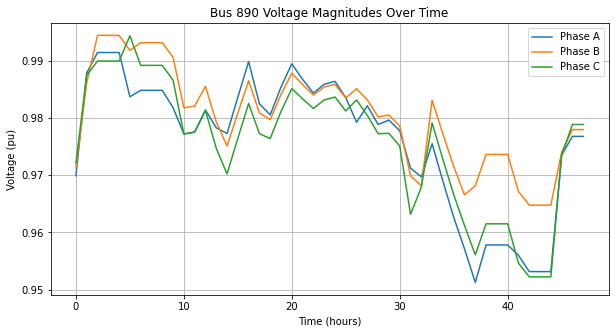

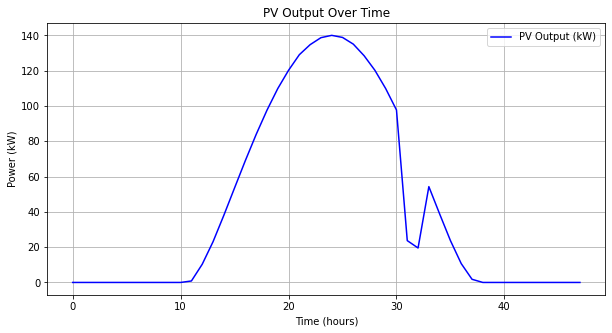

In [45]:
target_bus = '890'
# -- Plot 1: 3-Phase Voltage Magnitudes over Time --

Volt = V_node_Sc[target_bus]
plt.figure(figsize=(10,5))
plt.plot([v[0] for v in Volt ], label="Phase A")
plt.plot([v[1] for v in Volt ], label="Phase B")
plt.plot([v[2] for v in Volt ], label="Phase C")
plt.xlabel("Time (hours)")
plt.ylabel("Voltage (pu)")
plt.title(f"Bus {target_bus} Voltage Magnitudes Over Time")
plt.grid(True)
plt.legend()
plt.show()



plt.figure(figsize=(10,5))
plt.plot(powers_Sc[1], label="PV Output (kW)", color='blue')
plt.xlabel("Time (hours)")
plt.ylabel("Power (kW)")
plt.title("PV Output Over Time")
plt.grid(True)
plt.legend()
plt.show()

# Times matching 30-minute steps
irr_times = [i * 5/60 for i in range(len(irradiance_day))]  # 0.0, 0.5, 1.0, ..., 23.5


# plt.figure(figsize=(10,5))
# plt.plot(irr_times, irradiance_day, label="Irradiance", color='red')
# plt.plot(irr_times, attack_irradiance, label="Attack", color='blue')
# plt.xlabel("Time (hours)")
# plt.ylabel("Irradiance (W/m²)")
# plt.title("Solar Irradiance Profile Over 24 Hours")
# plt.grid(True)
# plt.legend()
# plt.show()



# Plot
# plt.figure(figsize=(10,5))
# plt.plot(range(24), loadshape_day, label="Loadshape", color='red')
# plt.xlabel("Time (hours)")
# plt.ylabel("Load Multiplier")
# plt.title("Load Profile Over 24 Hours")
# plt.grid(True)
# plt.legend()
# plt.show()

